In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px

In [2]:
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import pytorch_forecasting as ptf
from pytorch_forecasting import Baseline, TimeSeriesDataSet, DeepAR
from pytorch_forecasting.metrics.distributions import MultivariateNormalDistributionLoss
from pytorch_forecasting.metrics.point import RMSE

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
store_df = pd.read_csv('data/store.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

/tmp/ipykernel_11344/3598239639.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv')


In [4]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


## Data preprocessing

#### Checking any problems with the data

In [5]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The value 0 occurs in two data types

In [6]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [7]:
def one_hot_encode(df, column_name):
    one_hot_df = pd.get_dummies(df[column_name], prefix=column_name+"_", drop_first=False, dtype=int)
    new_cols = df.columns.drop(column_name)
    new_df = pd.concat([df[new_cols], one_hot_df], axis=1)
    return new_df

def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[df['StateHoliday'] == 0, 'StateHoliday'] = '0'
    # df = one_hot_encode(df, 'StateHoliday')
    df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)
    # df = df.iloc[::-1].reset_index(drop=True)
    
    return df
    

In [8]:
train_df = preprocess_data(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,1,3,2013-01-02,5530,668,1,0,0,1
2,1,4,2013-01-03,4327,578,1,0,0,1
3,1,5,2013-01-04,4486,619,1,0,0,1
4,1,6,2013-01-05,4997,635,1,0,0,1


In [9]:
test_df = preprocess_data(test_df)
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,40233,1,6,2015-08-01,1.0,0,0,1
1,39377,1,7,2015-08-02,0.0,0,0,1
2,38521,1,1,2015-08-03,1.0,1,0,1
3,37665,1,2,2015-08-04,1.0,1,0,1
4,36809,1,3,2015-08-05,1.0,1,0,1


In [10]:
test_df[test_df['Store'] == 1011].shape

(48, 8)

#### Looking at the data of a random store

In [11]:
df_store_x = train_df[train_df['Store'] == 1011]
df_store_x

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
921243,1011,2,2013-01-01,0,0,0,0,a,1
921244,1011,3,2013-01-02,7049,900,1,0,0,1
921245,1011,4,2013-01-03,6377,802,1,0,0,1
921246,1011,5,2013-01-04,5981,793,1,0,0,1
921247,1011,6,2013-01-05,7963,1043,1,0,0,0
...,...,...,...,...,...,...,...,...,...
922180,1011,1,2015-07-27,10066,902,1,1,0,1
922181,1011,2,2015-07-28,8673,834,1,1,0,1
922182,1011,3,2015-07-29,7755,732,1,1,0,1
922183,1011,4,2015-07-30,9227,877,1,1,0,1


## Exploring LSTM model.

In [12]:
df_store_x.loc[:, "TimeIndex"] = range(0, len(df_store_x))

/tmp/ipykernel_11344/359616140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_x.loc[:, "TimeIndex"] = range(0, len(df_store_x))


Modifying the datatypes to make dataset compatible with LSTM

In [13]:
# df.astype({'col1': 'int32'}).dtypes
df_store_x = df_store_x.astype({'Store': 'str', 'DayOfWeek': 'str', 'Open': 'str', 'Promo': 'str', 'StateHoliday': 'str', 
                                'SchoolHoliday': 'str', 'Sales': 'float64'})

In [14]:
df_store_x.dtypes

Store                    object
DayOfWeek                object
Date             datetime64[ns]
Sales                   float64
Customers                 int64
Open                     object
Promo                    object
StateHoliday             object
SchoolHoliday            object
TimeIndex                 int64
dtype: object

In [15]:
df_store_x.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,TimeIndex
921243,1011,2,2013-01-01,0.0,0,0,0,a,1,0
921244,1011,3,2013-01-02,7049.0,900,1,0,0,1,1
921245,1011,4,2013-01-03,6377.0,802,1,0,0,1,2
921246,1011,5,2013-01-04,5981.0,793,1,0,0,1,3
921247,1011,6,2013-01-05,7963.0,1043,1,0,0,0,4


In [16]:
df_store_x.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,TimeIndex
922180,1011,1,2015-07-27,10066.0,902,1,1,0,1,937
922181,1011,2,2015-07-28,8673.0,834,1,1,0,1,938
922182,1011,3,2015-07-29,7755.0,732,1,1,0,1,939
922183,1011,4,2015-07-30,9227.0,877,1,1,0,1,940
922184,1011,5,2015-07-31,10134.0,1021,1,1,0,1,941


In [17]:
store_train_df = df_store_x[:-49]
store_test_df = df_store_x[-49:]

In [18]:
store_train_df.shape

(893, 10)

### Data loader

In [19]:
max_encoder_length = 490
max_prediction_length = 49
training_cutoff = df_store_x["TimeIndex"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_store_x[lambda x: x.TimeIndex <= training_cutoff],
    time_idx="TimeIndex",
    target="Sales",
    group_ids=["Store"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Sales"],
    static_categoricals=["Store"],
    # time_varying_known_reals=["DayOfWeek"],
    time_varying_known_categoricals=["DayOfWeek", "Open", "Promo", "StateHoliday"],
)

validation = TimeSeriesDataSet.from_dataset(training, df_store_x, min_prediction_idx=training_cutoff + 1)

In [20]:
train_loader = training.to_dataloader(train=True, batch_size=512, batch_sampler="synchronized")
test_loader = validation.to_dataloader(train=False, batch_size=49, batch_sampler="synchronized")

### Baseline model

Baseline model uses last known target value to make prediction. Fitting baseline model for comparison.

In [21]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(test_loader, trainer_kwargs=dict(accelerator="auto"), return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, rea

tensor(2946.2903, device='cuda:0')

### LSTM model

In [22]:
pl.seed_everything(42)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=10, verbose=False, mode="min")
lstm_trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True
)

net = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    log_interval=10,
    log_val_interval=1,
    cell_type="LSTM",
    hidden_size=50,
    rnn_layers=3,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=2),
)

lstm_trainer.fit(
    net,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | Multivari

Sanity Checking: |                                                                                            …

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [23]:
best_model_path = lstm_trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

predictions = best_model.predict(test_loader, trainer_kwargs=dict(accelerator="auto"), return_y=True)
lstm_rmse = RMSE()(predictions.output, predictions.y).cpu().item()
print("LSTM model rmse: ", lstm_rmse)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LSTM model rmse:  1275.117919921875


/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [24]:
y_pred = predictions.output.cpu().numpy().reshape(-1)
y_true = predictions.y[0].cpu().numpy().reshape(-1)

my_dict = {
    "LstmForecast": y_pred,
    "Sales": y_true
}
forecast_df = pd.DataFrame(my_dict)

In [25]:
forecast_df["Date"] = store_test_df["Date"].values

In [26]:
# forecast_df

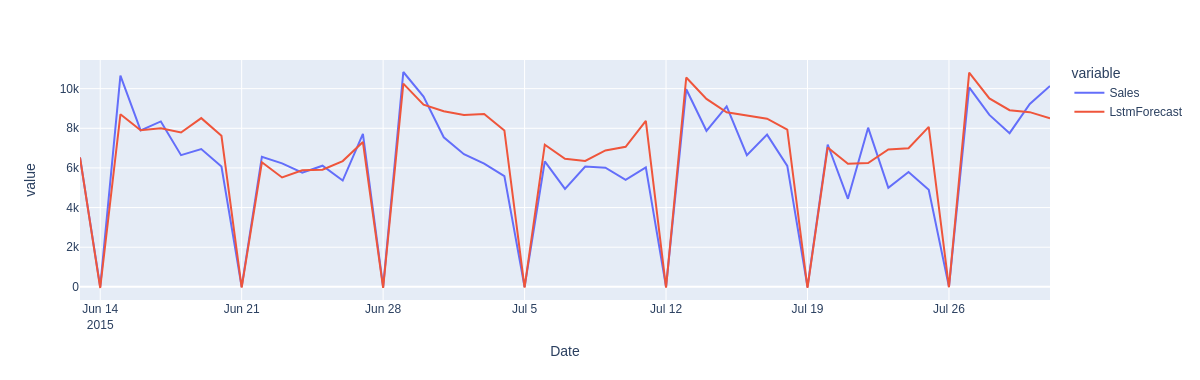

In [27]:
fig = px.line(forecast_df, x="Date", y=["Sales", "LstmForecast"], width=1200, height=380)
fig.show("png")

### GRU model

In [28]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=10, verbose=False, mode="min")
gru_trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
    # logger=tensorboard
)

net = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    log_interval=10,
    log_val_interval=1,
    cell_type="GRU",
    dropout=0.2,
    hidden_size=50,
    rnn_layers=5,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=2),
)

gru_trainer.fit(
    net,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss               

Sanity Checking: |                                                                                            …

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.

/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [29]:
best_model_path = gru_trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

predictions = best_model.predict(test_loader, trainer_kwargs=dict(accelerator="auto"), return_y=True)
gru_rmse = RMSE()(predictions.output, predictions.y).cpu().item()
gru_rmse

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/harsh242/mambaforge/envs/rossmann2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



1375.002197265625

In [30]:
y_pred = predictions.output.cpu().numpy().reshape(-1)

forecast_df["GruForecast"] = y_pred

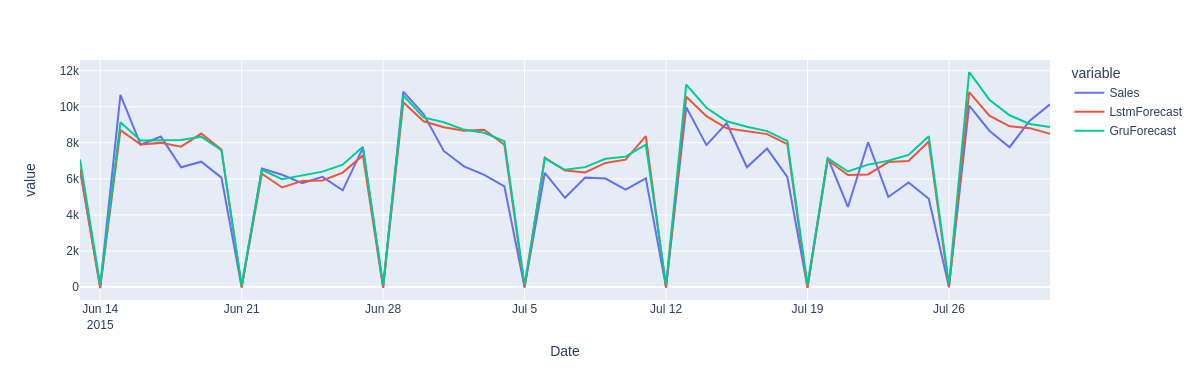

In [31]:
fig = px.line(forecast_df, x="Date", y=["Sales", "LstmForecast", "GruForecast"], width=1200, height=380)
fig.show("png")

## Conclusion

RMSE errors: \
Baseline - 2946\
LSTM - 1275\
GRU - 1375 \
SARIMAX - 1241

Although the best model is SARIMAX, LSTM comes very close. The advantage of LSTM is that we can use LSTM directly to predict sales for all the stores at once instead of running a loop through the store ids. 

The end!